In [2]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Feature Extraction

In [43]:
from PIL import Image
from sklearn.model_selection import train_test_split

'''CK+ dataset utils'''

class CKDataset(Dataset):
    def __init__(self, df, transformations):
        self.df = df
        self.transformations = transformations
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filepath, label = self.df.iloc[index]['filepath'], self.df.iloc[index]['label']
        img = Image.open(filepath).convert('RGB')
        img = self.transformations(img)
        return img, label
    

dir2label = {dir : i for i, dir in enumerate(os.listdir('D:/Vedanth/Major-Project/input/ckplus/CK+48'))}
print(dir2label)
ckplus_df = pd.DataFrame(columns=['filepath', 'label'])
for dir in os.listdir('D:/Vedanth/Major-Project/input/ckplus/CK+48'):
    label = dir2label[dir]
    for file in os.listdir(f'D:/Vedanth/Major-Project/input/ckplus/CK+48/{dir}'):
        filepath = f'D:/Vedanth/Major-Project/input/ckplus/CK+48/{dir}/{file}'
        ckplus_df = ckplus_df.append({'filepath' : filepath, 'label' : label}, ignore_index=True)
ckplus_df = ckplus_df.sample(frac=1)

ckplus_train, ckplus_test = train_test_split(ckplus_df, test_size=0.2, shuffle=True, random_state=0)
print(len(ckplus_train), len(ckplus_test))
ckplus_train.to_csv('ckplus_train.csv', index=False)
ckplus_test.to_csv('ckplus_test.csv', index=False)

{'surprise': 0, 'fear': 1, 'sadness': 2, 'disgust': 3, 'contempt': 4, 'happy': 5, 'anger': 6}
784 197


In [10]:
from PIL import Image
from sklearn.model_selection import train_test_split

# '''Tufts IR database utils'''

# class TuftsDataset(Dataset):
#     def __init__(self, df, transformations):
#         self.df = df
#         self.transformations = transformations
        
#     def __len__(self):
#         return len(self.df)
    
#     def __getitem__(self, index):
#         filepath, label = self.df.iloc[index]['filepath'], self.df.iloc[index]['label']
#         img = Image.open(filepath).convert('RGB')
#         img = self.transformations(img)
#         return img, label
    
'''
1,Neutral 2,Smile 3,Sleepy 4,Shock, 5,Sun_Glasses
'''

# tufts_df = pd.DataFrame(columns=['filepath', 'label'])
# for dir in os.listdir('/kaggle/input/Tufts/TD_IR_EMOTIONS_CROPPED'):
#     dirpath = f'/kaggle/input/Tufts/TD_IR_EMOTIONS_CROPPED/{dir}'
#     if os.path.isdir(dirpath):
#         for file in os.listdir(dirpath):
#             filepath = f'{dirpath}/{file}'
#             label = int(file.split('.jpg')[0][-1]) - 1
#             assert label>=0 and label<5
#             tufts_df = tufts_df.append({'filepath' : filepath, 'label' : label}, ignore_index=True)
# tufts_df = tufts_df.sample(frac=1)

# tufts_train, tufts_test = train_test_split(tufts_df, test_size=0.2, shuffle=True, random_state=0)
# print(len(tufts_train), np.unique(tufts_train.iloc[:]['label']), len(tufts_test), np.unique(tufts_test.iloc[:]['label']))
# tufts_train.to_csv('tufts_train.csv', index=False)
# tufts_test.to_csv('tufts_test.csv', index=False)

446 [0 1 2 3 4] 112 [0 1 2 3 4]


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

transformations = {
    'train' : transforms.Compose([
        transforms.Resize(224),
        # transforms.RandomAffine(degrees=(-180,180), translate=(0.1,0.1), scale=(0.9,1.1), shear=(-5,5)),
        transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val' : transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

traindata, valdata = TuftsDataset(tufts_train, transformations['train']), TuftsDataset(tufts_test, transformations['val'])
print(len(traindata), len(valdata))

# cls2idx = traindata.class_to_idx
cls2idx = {0:'Neutral', 1:'Smile', 2:'Sleepy', 3:'Shock', 4:'Sun_Glasses'}

# hyperparams
bs = 4
lr = 0.0002
n_classes = len(cls2idx)
n_epochs = 100
MODEL = 'efficientnet'
OPTI = "Adam"
LOSS = 'CE'
DATA = 'tufts'

trainloader, valloader = DataLoader(traindata, batch_size=bs, shuffle=True, num_workers=16), DataLoader(valdata, batch_size=bs, shuffle=False, num_workers=16) #, DataLoader(testdata, batch_size=bs, shuffle=False, num_workers=16)
print(len(trainloader), len(valloader))

model = torchvision.models.efficientnet_b0(pretrained=True)
model.classifier = nn.Linear(1280, n_classes)
model.to(device)

lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

best_acc, best_wts = 0.0, copy.deepcopy(model.state_dict())
for epoch in range(1, n_epochs+1):
    model.load_state_dict(best_wts)
    # training
    model.train()
    total_loss, total_num, train_bar = 0.0, 0, tqdm(trainloader)
    for data, targets in train_bar:
        outputs = model(data.to(device))
        loss = lossfun(outputs, targets.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_num += bs
        total_loss += loss.item() * bs
        train_bar.set_description('Train Epoch: [{}/{}] Loss: {:.4f}'.format(epoch, n_epochs, total_loss / total_num))
#     scheduler.step()
    # validation
    model.eval()
    n_samples, n_corrects, val_accs = 0, 0, []
    for data, targets in valloader:
        with torch.no_grad():
            outputs = model(data.to(device))
            batch_acc = accuracy_score(targets.numpy(), torch.argmax(F.softmax(outputs, dim=1), dim=1).cpu().detach().numpy())
            val_accs.append(batch_acc)
    accuracy = torch.tensor(val_accs).mean()
    print(f'Validation accuracy after {epoch} epochs: {accuracy:.6f}')
    # updating model after validation
    if accuracy >= best_acc:
        best_acc = accuracy
        best_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), f'{DATA}-{MODEL}_{lr}_{OPTI}_{LOSS}.pth')
    

print(f'==> Final Validation accuracy: {best_acc:.6f}')

446 112
112 28


Train Epoch: [1/100] Loss: 1.3285: 100%|██████████| 112/112 [00:07<00:00, 14.47it/s]


Validation accuracy after 1 epochs: 0.491071


Train Epoch: [2/100] Loss: 1.0044: 100%|██████████| 112/112 [00:06<00:00, 16.13it/s]


Validation accuracy after 2 epochs: 0.642857


Train Epoch: [3/100] Loss: 0.9394: 100%|██████████| 112/112 [00:07<00:00, 15.38it/s]


Validation accuracy after 3 epochs: 0.767857


Train Epoch: [4/100] Loss: 0.6997: 100%|██████████| 112/112 [00:06<00:00, 17.03it/s]


Validation accuracy after 4 epochs: 0.785714


Train Epoch: [5/100] Loss: 0.6015: 100%|██████████| 112/112 [00:06<00:00, 17.14it/s]


Validation accuracy after 5 epochs: 0.794643


Train Epoch: [6/100] Loss: 0.5263: 100%|██████████| 112/112 [00:06<00:00, 17.14it/s]


Validation accuracy after 6 epochs: 0.794643


Train Epoch: [7/100] Loss: 0.4347: 100%|██████████| 112/112 [00:07<00:00, 15.34it/s]


Validation accuracy after 7 epochs: 0.758929


Train Epoch: [8/100] Loss: 0.3444: 100%|██████████| 112/112 [00:06<00:00, 17.06it/s]


Validation accuracy after 8 epochs: 0.741071


Train Epoch: [9/100] Loss: 0.4531: 100%|██████████| 112/112 [00:06<00:00, 16.84it/s]


Validation accuracy after 9 epochs: 0.803571


Train Epoch: [10/100] Loss: 0.3790: 100%|██████████| 112/112 [00:06<00:00, 17.00it/s]


Validation accuracy after 10 epochs: 0.758929


Train Epoch: [11/100] Loss: 0.3674: 100%|██████████| 112/112 [00:06<00:00, 16.95it/s]


Validation accuracy after 11 epochs: 0.723214


Train Epoch: [12/100] Loss: 0.4039: 100%|██████████| 112/112 [00:06<00:00, 16.90it/s]


Validation accuracy after 12 epochs: 0.732143


Train Epoch: [13/100] Loss: 0.3613: 100%|██████████| 112/112 [00:06<00:00, 17.23it/s]


Validation accuracy after 13 epochs: 0.741071


Train Epoch: [14/100] Loss: 0.3302: 100%|██████████| 112/112 [00:07<00:00, 15.82it/s]


Validation accuracy after 14 epochs: 0.767857


Train Epoch: [15/100] Loss: 0.3779: 100%|██████████| 112/112 [00:06<00:00, 16.88it/s]


Validation accuracy after 15 epochs: 0.785714


Train Epoch: [16/100] Loss: 0.4155: 100%|██████████| 112/112 [00:06<00:00, 16.98it/s]


Validation accuracy after 16 epochs: 0.812500


Train Epoch: [17/100] Loss: 0.3801: 100%|██████████| 112/112 [00:06<00:00, 17.04it/s]


Validation accuracy after 17 epochs: 0.803571


Train Epoch: [18/100] Loss: 0.3537: 100%|██████████| 112/112 [00:07<00:00, 15.52it/s]


Validation accuracy after 18 epochs: 0.758929


Train Epoch: [19/100] Loss: 0.2777: 100%|██████████| 112/112 [00:06<00:00, 16.95it/s]


Validation accuracy after 19 epochs: 0.750000


Train Epoch: [20/100] Loss: 0.2795: 100%|██████████| 112/112 [00:06<00:00, 17.01it/s]


Validation accuracy after 20 epochs: 0.750000


Train Epoch: [21/100] Loss: 0.2713: 100%|██████████| 112/112 [00:06<00:00, 16.80it/s]


Validation accuracy after 21 epochs: 0.750000


Train Epoch: [22/100] Loss: 0.3347: 100%|██████████| 112/112 [00:07<00:00, 15.10it/s]


Validation accuracy after 22 epochs: 0.785714


Train Epoch: [23/100] Loss: 0.3226: 100%|██████████| 112/112 [00:06<00:00, 16.75it/s]


Validation accuracy after 23 epochs: 0.687500


Train Epoch: [24/100] Loss: 0.3096: 100%|██████████| 112/112 [00:06<00:00, 16.80it/s]


Validation accuracy after 24 epochs: 0.767857


Train Epoch: [25/100] Loss: 0.3431: 100%|██████████| 112/112 [00:06<00:00, 16.77it/s]


Validation accuracy after 25 epochs: 0.803571


Train Epoch: [26/100] Loss: 0.3425: 100%|██████████| 112/112 [00:06<00:00, 16.97it/s]


Validation accuracy after 26 epochs: 0.741071


Train Epoch: [27/100] Loss: 0.2951: 100%|██████████| 112/112 [00:06<00:00, 16.66it/s]


Validation accuracy after 27 epochs: 0.767857


Train Epoch: [28/100] Loss: 0.2926: 100%|██████████| 112/112 [00:06<00:00, 16.67it/s]


Validation accuracy after 28 epochs: 0.785714


Train Epoch: [29/100] Loss: 0.3419: 100%|██████████| 112/112 [00:07<00:00, 15.43it/s]


Validation accuracy after 29 epochs: 0.839286


Train Epoch: [30/100] Loss: 0.2600: 100%|██████████| 112/112 [00:07<00:00, 15.40it/s]


Validation accuracy after 30 epochs: 0.812500


Train Epoch: [31/100] Loss: 0.2720: 100%|██████████| 112/112 [00:06<00:00, 16.53it/s]


Validation accuracy after 31 epochs: 0.758929


Train Epoch: [32/100] Loss: 0.3088: 100%|██████████| 112/112 [00:06<00:00, 16.69it/s]


Validation accuracy after 32 epochs: 0.776786


Train Epoch: [33/100] Loss: 0.2992: 100%|██████████| 112/112 [00:07<00:00, 15.30it/s]


Validation accuracy after 33 epochs: 0.776786


Train Epoch: [34/100] Loss: 0.2813: 100%|██████████| 112/112 [00:06<00:00, 16.67it/s]


Validation accuracy after 34 epochs: 0.821429


Train Epoch: [35/100] Loss: 0.3195: 100%|██████████| 112/112 [00:06<00:00, 16.61it/s]


Validation accuracy after 35 epochs: 0.794643


Train Epoch: [36/100] Loss: 0.2777: 100%|██████████| 112/112 [00:06<00:00, 16.76it/s]


Validation accuracy after 36 epochs: 0.821429


Train Epoch: [37/100] Loss: 0.2371: 100%|██████████| 112/112 [00:06<00:00, 16.11it/s]


Validation accuracy after 37 epochs: 0.776786


Train Epoch: [38/100] Loss: 0.3118: 100%|██████████| 112/112 [00:06<00:00, 17.06it/s]


Validation accuracy after 38 epochs: 0.776786


Train Epoch: [39/100] Loss: 0.3409: 100%|██████████| 112/112 [00:06<00:00, 16.60it/s]


Validation accuracy after 39 epochs: 0.821429


Train Epoch: [40/100] Loss: 0.2880: 100%|██████████| 112/112 [00:07<00:00, 15.54it/s]


Validation accuracy after 40 epochs: 0.794643


Train Epoch: [41/100] Loss: 0.2728: 100%|██████████| 112/112 [00:06<00:00, 16.62it/s]


Validation accuracy after 41 epochs: 0.785714


Train Epoch: [42/100] Loss: 0.2775: 100%|██████████| 112/112 [00:06<00:00, 16.69it/s]


Validation accuracy after 42 epochs: 0.821429


Train Epoch: [43/100] Loss: 0.2920: 100%|██████████| 112/112 [00:06<00:00, 16.61it/s]


Validation accuracy after 43 epochs: 0.758929


Train Epoch: [44/100] Loss: 0.2582: 100%|██████████| 112/112 [00:07<00:00, 14.65it/s]


Validation accuracy after 44 epochs: 0.830357


Train Epoch: [45/100] Loss: 0.3223: 100%|██████████| 112/112 [00:06<00:00, 16.61it/s]


Validation accuracy after 45 epochs: 0.794643


Train Epoch: [46/100] Loss: 0.2634: 100%|██████████| 112/112 [00:06<00:00, 16.73it/s]


Validation accuracy after 46 epochs: 0.812500


Train Epoch: [47/100] Loss: 0.2870: 100%|██████████| 112/112 [00:06<00:00, 16.78it/s]


Validation accuracy after 47 epochs: 0.776786


Train Epoch: [48/100] Loss: 0.2780: 100%|██████████| 112/112 [00:07<00:00, 15.12it/s]


Validation accuracy after 48 epochs: 0.767857


Train Epoch: [49/100] Loss: 0.2631: 100%|██████████| 112/112 [00:06<00:00, 16.89it/s]


Validation accuracy after 49 epochs: 0.794643


Train Epoch: [50/100] Loss: 0.2933: 100%|██████████| 112/112 [00:06<00:00, 16.57it/s]


Validation accuracy after 50 epochs: 0.758929


Train Epoch: [51/100] Loss: 0.3444: 100%|██████████| 112/112 [00:06<00:00, 16.10it/s]


Validation accuracy after 51 epochs: 0.758929


Train Epoch: [52/100] Loss: 0.3139: 100%|██████████| 112/112 [00:06<00:00, 17.13it/s]


Validation accuracy after 52 epochs: 0.723214


Train Epoch: [53/100] Loss: 0.3111: 100%|██████████| 112/112 [00:06<00:00, 17.19it/s]


Validation accuracy after 53 epochs: 0.839286


Train Epoch: [54/100] Loss: 0.2843: 100%|██████████| 112/112 [00:06<00:00, 17.27it/s]


Validation accuracy after 54 epochs: 0.812500


Train Epoch: [55/100] Loss: 0.2805: 100%|██████████| 112/112 [00:07<00:00, 15.64it/s]


Validation accuracy after 55 epochs: 0.785714


Train Epoch: [56/100] Loss: 0.2655: 100%|██████████| 112/112 [00:06<00:00, 17.08it/s]


Validation accuracy after 56 epochs: 0.776786


Train Epoch: [57/100] Loss: 0.2914: 100%|██████████| 112/112 [00:06<00:00, 16.96it/s]


Validation accuracy after 57 epochs: 0.821429


Train Epoch: [58/100] Loss: 0.2803: 100%|██████████| 112/112 [00:06<00:00, 16.76it/s]


Validation accuracy after 58 epochs: 0.750000


Train Epoch: [59/100] Loss: 0.2738: 100%|██████████| 112/112 [00:07<00:00, 14.72it/s]


Validation accuracy after 59 epochs: 0.812500


Train Epoch: [60/100] Loss: 0.2878: 100%|██████████| 112/112 [00:06<00:00, 17.01it/s]


Validation accuracy after 60 epochs: 0.758929


Train Epoch: [61/100] Loss: 0.2649: 100%|██████████| 112/112 [00:06<00:00, 17.18it/s]


Validation accuracy after 61 epochs: 0.750000


Train Epoch: [62/100] Loss: 0.2692: 100%|██████████| 112/112 [00:06<00:00, 17.05it/s]


Validation accuracy after 62 epochs: 0.812500


Train Epoch: [63/100] Loss: 0.2878: 100%|██████████| 112/112 [00:07<00:00, 15.36it/s]


Validation accuracy after 63 epochs: 0.785714


Train Epoch: [64/100] Loss: 0.2939: 100%|██████████| 112/112 [00:06<00:00, 16.93it/s]


Validation accuracy after 64 epochs: 0.821429


Train Epoch: [65/100] Loss: 0.2292: 100%|██████████| 112/112 [00:06<00:00, 17.17it/s]


Validation accuracy after 65 epochs: 0.812500


Train Epoch: [66/100] Loss: 0.2433: 100%|██████████| 112/112 [00:06<00:00, 17.24it/s]


Validation accuracy after 66 epochs: 0.776786


Train Epoch: [67/100] Loss: 0.2790: 100%|██████████| 112/112 [00:06<00:00, 17.16it/s]


Validation accuracy after 67 epochs: 0.848214


Train Epoch: [68/100] Loss: 0.2255: 100%|██████████| 112/112 [00:06<00:00, 17.04it/s]


Validation accuracy after 68 epochs: 0.812500


Train Epoch: [69/100] Loss: 0.2208: 100%|██████████| 112/112 [00:06<00:00, 17.08it/s]


Validation accuracy after 69 epochs: 0.794643


Train Epoch: [70/100] Loss: 0.2234: 100%|██████████| 112/112 [00:07<00:00, 15.94it/s]


Validation accuracy after 70 epochs: 0.794643


Train Epoch: [71/100] Loss: 0.2476: 100%|██████████| 112/112 [00:06<00:00, 17.02it/s]


Validation accuracy after 71 epochs: 0.839286


Train Epoch: [72/100] Loss: 0.2291: 100%|██████████| 112/112 [00:06<00:00, 17.23it/s]


Validation accuracy after 72 epochs: 0.821429


Train Epoch: [73/100] Loss: 0.1795: 100%|██████████| 112/112 [00:06<00:00, 16.47it/s]


Validation accuracy after 73 epochs: 0.758929


Train Epoch: [74/100] Loss: 0.2067: 100%|██████████| 112/112 [00:07<00:00, 15.54it/s]


Validation accuracy after 74 epochs: 0.767857


Train Epoch: [75/100] Loss: 0.2341: 100%|██████████| 112/112 [00:06<00:00, 17.03it/s]


Validation accuracy after 75 epochs: 0.758929


Train Epoch: [76/100] Loss: 0.2408: 100%|██████████| 112/112 [00:06<00:00, 17.08it/s]


Validation accuracy after 76 epochs: 0.758929


Train Epoch: [77/100] Loss: 0.2366: 100%|██████████| 112/112 [00:06<00:00, 16.99it/s]


Validation accuracy after 77 epochs: 0.794643


Train Epoch: [78/100] Loss: 0.2201: 100%|██████████| 112/112 [00:07<00:00, 15.66it/s]


Validation accuracy after 78 epochs: 0.767857


Train Epoch: [79/100] Loss: 0.2264: 100%|██████████| 112/112 [00:06<00:00, 17.15it/s]


Validation accuracy after 79 epochs: 0.785714


Train Epoch: [80/100] Loss: 0.2265: 100%|██████████| 112/112 [00:06<00:00, 16.99it/s]


Validation accuracy after 80 epochs: 0.758929


Train Epoch: [81/100] Loss: 0.2657: 100%|██████████| 112/112 [00:06<00:00, 16.98it/s]


Validation accuracy after 81 epochs: 0.848214


Train Epoch: [82/100] Loss: 0.2679: 100%|██████████| 112/112 [00:07<00:00, 15.57it/s]


Validation accuracy after 82 epochs: 0.750000


Train Epoch: [83/100] Loss: 0.3249: 100%|██████████| 112/112 [00:06<00:00, 17.13it/s]


Validation accuracy after 83 epochs: 0.741071


Train Epoch: [84/100] Loss: 0.2893: 100%|██████████| 112/112 [00:06<00:00, 17.25it/s]


Validation accuracy after 84 epochs: 0.794643


Train Epoch: [85/100] Loss: 0.2123: 100%|██████████| 112/112 [00:06<00:00, 16.08it/s]


Validation accuracy after 85 epochs: 0.803571


Train Epoch: [86/100] Loss: 0.2090: 100%|██████████| 112/112 [00:06<00:00, 17.22it/s]


Validation accuracy after 86 epochs: 0.732143


Train Epoch: [87/100] Loss: 0.2559: 100%|██████████| 112/112 [00:06<00:00, 16.25it/s]


Validation accuracy after 87 epochs: 0.812500


Train Epoch: [88/100] Loss: 0.2558: 100%|██████████| 112/112 [00:06<00:00, 16.86it/s]


Validation accuracy after 88 epochs: 0.741071


Train Epoch: [89/100] Loss: 0.1875: 100%|██████████| 112/112 [00:07<00:00, 15.59it/s]


Validation accuracy after 89 epochs: 0.785714


Train Epoch: [90/100] Loss: 0.2573: 100%|██████████| 112/112 [00:06<00:00, 17.05it/s]


Validation accuracy after 90 epochs: 0.821429


Train Epoch: [91/100] Loss: 0.2742: 100%|██████████| 112/112 [00:06<00:00, 17.21it/s]


Validation accuracy after 91 epochs: 0.723214


Train Epoch: [92/100] Loss: 0.2482: 100%|██████████| 112/112 [00:06<00:00, 17.26it/s]


Validation accuracy after 92 epochs: 0.776786


Train Epoch: [93/100] Loss: 0.2459: 100%|██████████| 112/112 [00:07<00:00, 15.59it/s]


Validation accuracy after 93 epochs: 0.794643


Train Epoch: [94/100] Loss: 0.2593: 100%|██████████| 112/112 [00:06<00:00, 17.05it/s]


Validation accuracy after 94 epochs: 0.803571


Train Epoch: [95/100] Loss: 0.2184: 100%|██████████| 112/112 [00:06<00:00, 17.01it/s]


Validation accuracy after 95 epochs: 0.767857


Train Epoch: [96/100] Loss: 0.2499: 100%|██████████| 112/112 [00:06<00:00, 17.06it/s]


Validation accuracy after 96 epochs: 0.767857


Train Epoch: [97/100] Loss: 0.1929: 100%|██████████| 112/112 [00:07<00:00, 15.75it/s]


Validation accuracy after 97 epochs: 0.821429


Train Epoch: [98/100] Loss: 0.2994: 100%|██████████| 112/112 [00:06<00:00, 17.09it/s]


Validation accuracy after 98 epochs: 0.812500


Train Epoch: [99/100] Loss: 0.2739: 100%|██████████| 112/112 [00:06<00:00, 17.04it/s]


Validation accuracy after 99 epochs: 0.848214


Train Epoch: [100/100] Loss: 0.2020: 100%|██████████| 112/112 [00:06<00:00, 17.13it/s]


Validation accuracy after 100 epochs: 0.794643
==> Final Validation accuracy: 0.848214


In [12]:
model.load_state_dict(best_wts)
model.classifier = nn.Identity()

X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []
with torch.no_grad():
    for data, targets in trainloader:
        feature = model(data.to(device))
        X_train.append(feature)
        y_train.append(targets)
    X_train, y_train = torch.cat(X_train, dim=0).contiguous().cpu().numpy(), torch.cat(y_train, dim=0).contiguous().numpy()
    for data, targets in valloader:
        feature = model(data.to(device))
        X_test.append(feature)
        y_test.append(targets)
    X_test, y_test = torch.cat(X_test, dim=0).contiguous().cpu().numpy(), torch.cat(y_test, dim=0).contiguous().numpy()
    
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(446, 1280) (446,) (112, 1280) (112,)


In [3]:
jaffe_train, jaffe_test = pd.read_csv('D:/Vedanth/Major-Project/ckplus-efficientnet_0.0005_Adam_CE-Train.csv'), pd.read_csv('D:/Vedanth/Major-Project/ckplus-efficientnet_0.0005_Adam_CE-Val.csv')
X_train = np.array(jaffe_train.iloc[:,0:(jaffe_train.shape[1]-1)].copy())
y_train = np.array(jaffe_train['label'].copy())
X_test = np.array(jaffe_test.iloc[:,0:(jaffe_test.shape[1]-1)].copy())
y_test = np.array(jaffe_test['label'].copy())

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(784, 1280) (784,) (197, 1280) (197,)


In [76]:
classes sorted(entry.name for entry in os.scandir('/D:/Vedanth/Major-Project/input/jaffe10/jaffe10test/jaffedbase/train') if entry.is_dir())
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
print(class_to_idx)

{'ANGRY': 0, 'FEAR': 1, 'HAPPY': 2, 'NEUTRAL': 3, 'SAD': 4, 'SURPRISE': 5, 'disgust': 6}


In [1]:
while True:pass

KeyboardInterrupt: 

Classification with KNN classifier on raw features
 --------------------------------------------------
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        41
           1     1.0000    1.0000    1.0000        17
           2     1.0000    1.0000    1.0000        21
           3     1.0000    1.0000    1.0000        31
           4     1.0000    0.6667    0.8000        12
           5     0.9167    1.0000    0.9565        44
           6     1.0000    1.0000    1.0000        31

    accuracy                         0.9797       197
   macro avg     0.9881    0.9524    0.9652       197
weighted avg     0.9814    0.9797    0.9781       197



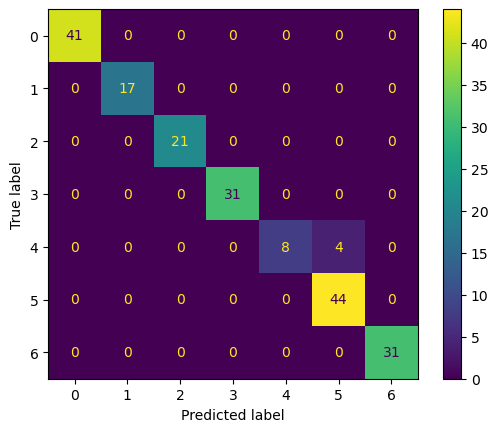

In [108]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC as SVM
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

clf = KNN(n_neighbors=100)
clf.fit(X_train, y_train)
y_preds = clf.predict(X_test)
print('Classification with KNN classifier on raw features\n', '-'*50)
print(classification_report(y_test, y_preds, digits=4))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_preds)).plot()
plt.show()

## Filter methods

In [49]:
def normalize(vector, lb=0, ub=1):
    # function to normalize a numpy vector in [lb, ub]
    norm_vector = np.zeros(vector.shape[0])
    maximum = max(vector)
    minimum = min(vector)
    norm_vector = lb + ((vector - minimum)/(maximum - minimum)) * (ub - lb)

    return norm_vector

class Result():
    # structure of the result
    def __init__(self):
        self.ranks = None
        self.scores = None
        self.features = None
        self.ranked_features = None 

In [50]:
### Filter method functions ###
from sklearn.feature_selection import chi2, mutual_info_classif

def FisherScore(data,target):
    mean = np.mean(data)
    sigma = np.var(data)
    unique = np.unique(target)
    mu = np.zeros(shape=(data.shape[1],unique.shape[0]))
    n = np.zeros(shape=(unique.shape[0],))
    var = np.zeros(shape=(data.shape[1],unique.shape[0]))
    for j in range(data.shape[1]):
        for i,u in enumerate(unique):
            d = data[np.where(target==u)[0]]
            n[i] = d.shape[0]
            mu[j,i] = np.mean(d[j])
            var[j,i] = np.var(d[j])
    fisher = np.zeros(data.shape[1])
    for j in range(data.shape[1]):
        sum1=0
        sum2=0
        for i,u in enumerate(unique):
            sum1+=n[i]*((mu[j,i]-mean)**2)
            sum2+=n[i]*var[j,i]
        fisher[j] = sum1/sum2
    feature_values = np.array(data)
    result = Result()
    result.features = feature_values
    result.scores = fisher
    result.ranks = np.argsort(np.argsort(fisher))
    result.ranked_features = feature_values[:, result.ranks]
    return result


def DispersionRatio(data,target):
    data[np.where(data==0)[0]] = 1
    var = np.var(data,axis=0)
    mean = np.mean(data,axis=0)
    disp_ratio = var/mean
    feature_values = np.array(data)
    result = Result()
    result.features = feature_values
    result.scores = disp_ratio
    result.ranks = np.argsort(np.argsort(disp_ratio))
    result.ranked_features = feature_values[:, result.ranks]
    return result


def PasiLuukka(in_data, target, measure = 'luca', p = 1):
    d = pd.DataFrame(in_data)
    t = pd.DataFrame(target)
    data = pd.concat([d,t],axis=1)
    
    # Feature selection method using similarity measure and fuzzy entropy 
    # measures based on the article:
    # P. Luukka, (2011) Feature Selection Using Fuzzy Entropy Measures with
    # Similarity Classifier, Expert Systems with Applications, 38, pp. 4600-4607

    l = int(max(data.iloc[:,-1]))
    m = data.shape[0]
    t = data.shape[1]-1
    
    dataold = data.copy()
    
    idealvec_s = np.zeros((l,t)) 
    for k in range(l):
        idx = data.iloc[:,-1] == k+1
        idealvec_s[k,:] = data[idx].iloc[:,:-1].mean(axis = 0)
    
    # scaling data between [0,1]
    data_v = data.iloc[:,:-1]
    data_c = data.iloc[:,-1] # labels
    mins_v = data_v.min(axis = 0)
    Ones   = np.ones((data_v.shape))
    data_v = data_v + np.dot(Ones,np.diag(abs(mins_v)))
    
    tmp =[]
    for k in range(l):
        tmp.append(abs(mins_v))
    
    idealvec_s = idealvec_s+tmp
    maxs_v     = data_v.max(axis = 0)
    data_v     = np.dot(data_v,np.diag(maxs_v**(-1)))
    tmp2 =[];
    for k in range(l):
        tmp2.append(abs(maxs_v))
        
    idealvec_s = idealvec_s/tmp2
    
    data_vv = pd.DataFrame(data_v) # Convert the array of feature to a dataframe
    data    = pd.concat([data_vv, data_c], axis=1, ignore_index=False)

    # sample data
    datalearn_s = data.iloc[:,:-1]
    
    # similarities
    sim = np.zeros((t,m,l))
    
    for j in range(m):
        for i in range(t):
            for k in range(l):
                sim[i,j,k] = (1-abs(idealvec_s[k,i]**p - datalearn_s.iloc[j,i])**p)**(1/p)
            
    sim = sim.reshape(t,m*l)
    
    # possibility for two different entropy measures
    if measure =='luca':
        # moodifying zero and one values of the similarity values to work with 
        # De Luca's entropy measure
        delta = 1e-10
        sim[sim == 1] = delta
        sim[sim == 0] = 1-delta
        H = (-sim*np.log(sim)-(1-sim)*np.log(1-sim)).sum(axis = 1)
    elif measure == 'park':
        H = (np.sin(np.pi/2*sim)+np.sin(np.pi/2*(1-sim))-1).sum(axis = 1) 
        
    feature_values = np.array(in_data)
    result = Result()
    result.features = feature_values
    result.scores = H
    result.ranks = np.argsort(np.argsort(-H))
    result.ranked_features = feature_values[:, result.ranks]
    return result




(143, 1280) (70, 1280) (143,) (70,)
(213, 1280) (213,)
(143, 512) (70, 512) (143,) (70,)
Classification with KNN classifier on Information Gain rankings
 --------------------------------------------------
              precision    recall  f1-score   support

           0     1.0000    0.9000    0.9474        10
           1     1.0000    1.0000    1.0000        10
           2     1.0000    0.9000    0.9474        10
           3     0.9091    1.0000    0.9524        10
           4     0.9091    1.0000    0.9524        10
           5     1.0000    1.0000    1.0000        10
           6     1.0000    1.0000    1.0000        10

    accuracy                         0.9714        70
   macro avg     0.9740    0.9714    0.9714        70
weighted avg     0.9740    0.9714    0.9714        70



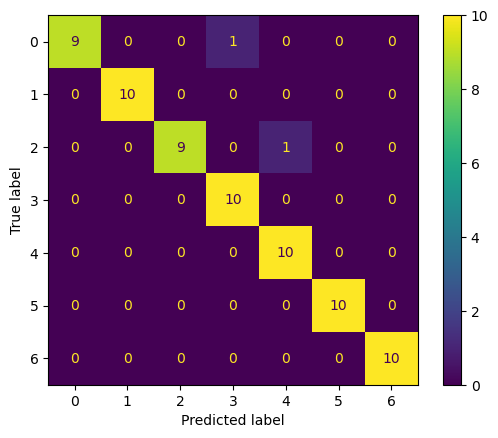

In [52]:
# get full X and y
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X, y = np.concatenate((X_train, X_test), axis=0), np.concatenate((y_train, y_test), axis=0)
print(X.shape, y.shape)

sol_filter_IG = InformationGain(X, y)
B = sol_filter_IG.ranked_features[:, 0:512]

# classification
X_tr, X_te, y_tr, y_te = B[0:X_train.shape[0], :], B[X_train.shape[0]:X.shape[0], :], y[0:y_train.shape[0]], y[y_train.shape[0]:y.shape[0]]
print(X_tr.shape, X_te.shape, y_tr.shape, y_te.shape)

clf = KNN(n_neighbors=20)
clf.fit(X_tr, y_tr)
y_pre = clf.predict(X_te)
print('Classification with KNN classifier on Information Gain rankings\n', '-'*50)
print(classification_report(y_te, y_pre, digits=4))
ConfusionMatrixDisplay(confusion_matrix(y_te, y_pre)).plot()

(446, 1280) (112, 1280) (446,) (112,)
(558, 1280) (558,)
(446, 512) (112, 512) (446,) (112,)
Classification with KNN classifier on Pasi-Luukka ranking
 --------------------------------------------------
              precision    recall  f1-score   support

           0     0.7083    0.7727    0.7391        22
           1     0.7059    0.6667    0.6857        18
           2     0.7222    0.8667    0.7879        15
           3     1.0000    0.8519    0.9200        27
           4     1.0000    1.0000    1.0000        30

    accuracy                         0.8482       112
   macro avg     0.8273    0.8316    0.8265       112
weighted avg     0.8582    0.8482    0.8506       112



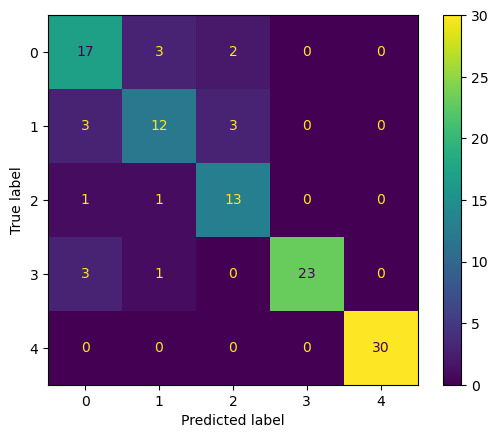

In [26]:
# get full X and y
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X, y = np.concatenate((X_train, X_test), axis=0), np.concatenate((y_train, y_test), axis=0)
print(X.shape, y.shape)

sol_filter_PL = PasiLuukka(X, y)
C = sol_filter_PL.ranked_features[:, 0:512]

# classification
X_tr, X_te, y_tr, y_te = C[0:X_train.shape[0], :], C[X_train.shape[0]:X.shape[0], :], y[0:y_train.shape[0]], y[y_train.shape[0]:y.shape[0]]
print(X_tr.shape, X_te.shape, y_tr.shape, y_te.shape)

clf = KNN(n_neighbors=5)
clf.fit(X_tr, y_tr)
y_pre = clf.predict(X_te)
print('Classification with KNN classifier on Pasi-Luukka ranking\n', '-'*50)
print(classification_report(y_te, y_pre, digits=4))
ConfusionMatrixDisplay(confusion_matrix(y_te, y_pre)).plot()

## Feature Selection

In [1]:
import os, sys, random, math, csv, time, pytz
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC as SVM
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold
from datetime import datetime, timezone, timedelta
random.seed(1)
np.random.seed(1)

NameError: name 'np' is not defined

In [24]:
df_train, df_test = pd.read_csv('/kaggle/working/fer2013-efficientnet_0.0005_Adam_CE-Train.csv'), pd.read_csv('/kaggle/working/fer2013-efficientnet_0.0005_Adam_CE-Test.csv')

X_train = np.array(df_train.iloc[:,0:(df_train.shape[1]-1)].copy())
y_train = np.array(df_train['label'].copy())
X_test = np.array(df_test.iloc[:,0:(df_test.shape[1]-1)].copy())
y_test = np.array(df_test['label'].copy())

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(28709, 1280) (28709,) (3589, 1280) (3589,)


Classification with KNN classifier on raw features
 --------------------------------------------------
              precision    recall  f1-score   support

           0     0.6427    0.6375    0.6401       491
           1     0.8667    0.7091    0.7800        55
           2     0.5714    0.5000    0.5333       528
           3     0.8773    0.8783    0.8778       879
           4     0.6459    0.6965    0.6703       626
           5     0.5825    0.5943    0.5883       594
           6     0.7949    0.8293    0.8118       416

    accuracy                         0.7027      3589
   macro avg     0.7116    0.6921    0.7002      3589
weighted avg     0.7013    0.7027    0.7013      3589



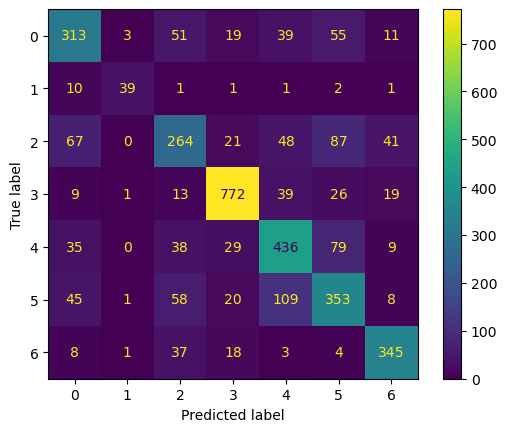

In [32]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC as SVM
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

clf = KNN(n_neighbors=5)
clf.fit(X_train, y_train)
y_preds = clf.predict(X_test)
print('Classification with KNN classifier on raw features\n', '-'*50)
print(classification_report(y_test, y_preds, digits=4))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_preds)).plot()
# plt.savefig('fer2013-effnet-KNN.png', dpi=300)
plt.show()

# clf = SVM()
# clf.fit(X_train, y_train)
# y_preds = clf.predict(X_test)
# print('\nClassification with SVM classifier on raw features\n', '-'*50)
# print(classification_report(y_test, y_preds, digits=4))
# ConfusionMatrixDisplay(confusion_matrix(y_test, y_preds)).plot()
# plt.savefig('fer2013-effnet-SVM.png', dpi=300)
plt.show()

# clf = MLP()
# clf.fit(X_train, y_train)
# y_preds = clf.predict(X_test)
# print('\nClassification with KNN classifier\n', '-'*50)
# print(classification_report(y_test, y_pred, digits=4))

In [5]:
class Solution():    
    #structure of the solution 
    def __init__(self):
        self.num_features = None
        self.num_agents = None
        self.max_iter = None
        self.obj_function = None
        self.execution_time = None
        self.convergence_curve = {}
        self.best_agent = None
        self.best_fitness = None
        self.best_accuracy = None
        self.final_population = None
        self.final_fitness = None
        self.final_accuracy = None


class Data():
    # structure of the training data
    def __init__(self):
        self.train_X = None
        self.train_Y = None
        self.val_X = None
        self.val_Y = None



def initialize(num_agents, num_features):
    # define min and max number of features
    min_features = int(0.5 * num_features)
    max_features = int(0.8 * num_features)

    # initialize the agents with zeros
    agents = np.zeros((num_agents, num_features))

    # select random features for each agent
    for agent_no in range(num_agents):

        random.seed(time.time() + agent_no)

        num = random.randint(min_features,max_features)
        pos = random.sample(range(0,num_features - 1),num)

        for idx in pos:
            agents[agent_no][idx] = 1 

    return agents



def sort_agents(agents, obj, data):
    # sort the agents according to fitness
    train_X, val_X, train_Y, val_Y = data.train_X, data.val_X, data.train_Y, data.val_Y
    (obj_function, weight_acc) = obj

    # if there is only one agent
    if len(agents.shape) == 1:
        num_agents = 1
        fitness, acc = obj_function(agents, train_X, val_X, train_Y, val_Y, weight_acc)
        return agents, fitness, acc

    # for multiple agents
    else:
        num_agents = agents.shape[0]
        fitness = np.zeros(num_agents)
        acc = np.zeros(num_agents)
        for id, agent in enumerate(agents):
            fitness[id], acc[id] = obj_function(agent, train_X, val_X, train_Y, val_Y, weight_acc)
        idx = np.argsort(-fitness)
        sorted_agents = agents[idx].copy()
        sorted_fitness = fitness[idx].copy()
        sorted_acc = acc[idx].copy()

    return sorted_agents, sorted_fitness, sorted_acc



def display(agents, fitness, acc, agent_name='Agent'):
    # display the population
    print('\nNumber of agents: {}'.format(agents.shape[0]))
    print('\n------------- Best Agent ---------------')
    print('Fitness: {}'.format(fitness[0]))
    print('Accuracy: {}'.format(acc[0]))
    print('Number of Features: {}'.format(int(np.sum(agents[0]))))
    print('----------------------------------------\n')

#     for id, agent in enumerate(agents):
#         print('{} {} - Fitness: {},Accuracy: {}, Number of Features: {}'.format(agent_name, id+1, fitness[id], acc[id], int(np.sum(agent))))

#     print('================================================================================\n')



def compute_accuracy(agent, train_X, test_X, train_Y, test_Y): 
    # compute classification accuracy of the given agents
    cols = np.flatnonzero(agent)     
    if(cols.shape[0] == 0):
        return 0    

#     clf = KNN()
    clf = SVM()

    train_data = train_X[:,cols]
    train_label = train_Y
    test_data = test_X[:,cols]
    test_label = test_Y

    clf.fit(train_data,train_label)
    acc = clf.score(test_data,test_label)

    return acc
        

def compute_fitness(agent, train_X, test_X, train_Y, test_Y, weight_acc=0.99,dims=None):
    # compute a basic fitness measure
    if(weight_acc == None):
        weight_acc = 0.9
    weight_feat = 1 - weight_acc
    
    agent = agent.reshape(-1)
    
    if dims != None:
        num_features = dims
    else:
        num_features = agent.shape[0]
    
    acc = compute_accuracy(agent, train_X, test_X, train_Y, test_Y)
    feat = (num_features - np.sum(agent))/num_features

    fitness = weight_acc * acc + weight_feat * feat
    
    return fitness, acc


### Transfer functions ###

def sigmoid(val):
    if val < 0:
        return 1 - 1/(1 + np.exp(val))
    else:
        return 1/(1 + np.exp(-val))

def v_func(val):
    return val/(np.sqrt(1 + val*val))

def z_func(val):
    return np.sqrt(1-np.power(5,-abs(val)))

def zz_func(val):
    return np.sqrt(1-np.power(8,-abs(val)))

def u_func(val):
    alpha, beta = 2, 1.5
    return alpha * np.power(abs(val), beta)


def get_trans_function(shape):
    if (shape.lower() == 's'):
        return sigmoid

    elif (shape.lower() == 'v'):
        return v_func

    elif(shape.lower() == 'u'):
        return u_func

    elif(shape.lower() == 'z'):
        return z_func
    
    elif(shape.lower() == 'zz'):
        return zz_func

    else:
        print('\n[Error!] We don\'t currently support {}-shaped transfer functions...\n'.format(shape))
        exit(1)